Import modules:

In [ ]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import cv2
import colorsys

import os
from google.colab import files, drive
import shutil
import json

import torch
import torch.utils.data
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
import sklearn.neighbors
#!pip3 install torchmetrics
#import torchmetrics
#from torchmetrics import classification
#import BinaryJaccardIndex, BinaryRecall, BinaryPrecision, BinaryF1Score

# set matplotlib figures global params
plt.rcParams['figure.dpi'] = 300

In [ ]:
!pip3 install --upgrade gdown

  Attempting uninstall: gdown
    Found existing installation: gdown 4.6.6
    Uninstalling gdown-4.6.6:
      Successfully uninstalled gdown-4.6.6


Download images:

In [ ]:
!gdown --fuzzy https://drive.google.com/file/d/1-ZbUe-shhNciAf0tRGZnHYHoaAdcvldC/view?usp=sharing # PdNi_anneal_100kx_-1um__16970-17043.zip

Downloading...
From (uriginal): https://drive.google.com/uc?id=1-ZbUe-shhNciAf0tRGZnHYHoaAdcvldC
From (redirected): https://drive.google.com/uc?id=1-ZbUe-shhNciAf0tRGZnHYHoaAdcvldC&confirm=t&uuid=43296220-83ef-4991-9519-075a6507e958
To: /content/PdNi_anneal_100kx_-1um__16970-17043.zip
100% 66.7M/66.7M [00:00<00:00, 246MB/s]


Download model:

In [ ]:
!gdown --fuzzy https://drive.google.com/file/d/12x-dGIMPhLFgaiOnahk53vXHG7EHwbTb/view?usp=share_link #bubbleMRCNN32layers_16873_epochs700_pretrained

Downloading...
From (uriginal): https://drive.google.com/uc?id=12x-dGIMPhLFgaiOnahk53vXHG7EHwbTb
From (redirected): https://drive.google.com/uc?id=12x-dGIMPhLFgaiOnahk53vXHG7EHwbTb&confirm=t&uuid=b6e724c0-e72f-4226-b613-a24f438c5798
To: /content/bubbleMRCNN32layers_16873_epochs700_pretrained.pt
100% 183M/183M [00:00<00:00, 223MB/s]


In [ ]:
def norm2D(img):
    return (img - np.amin(img))/np.ptp(img)

Load frames:

In [ ]:
# unzip the images
shutil.unpack_archive('PdNi_anneal_100kx_-1um__16970-17043.zip')

Show sample image:

In [ ]:
test_images = []
for i in range(30):
    imgNum = 16970 + i
    test_images.append(norm2D(plt.imread(f'PdNi_anneal_100kx_-1um__{imgNum}.tif')))

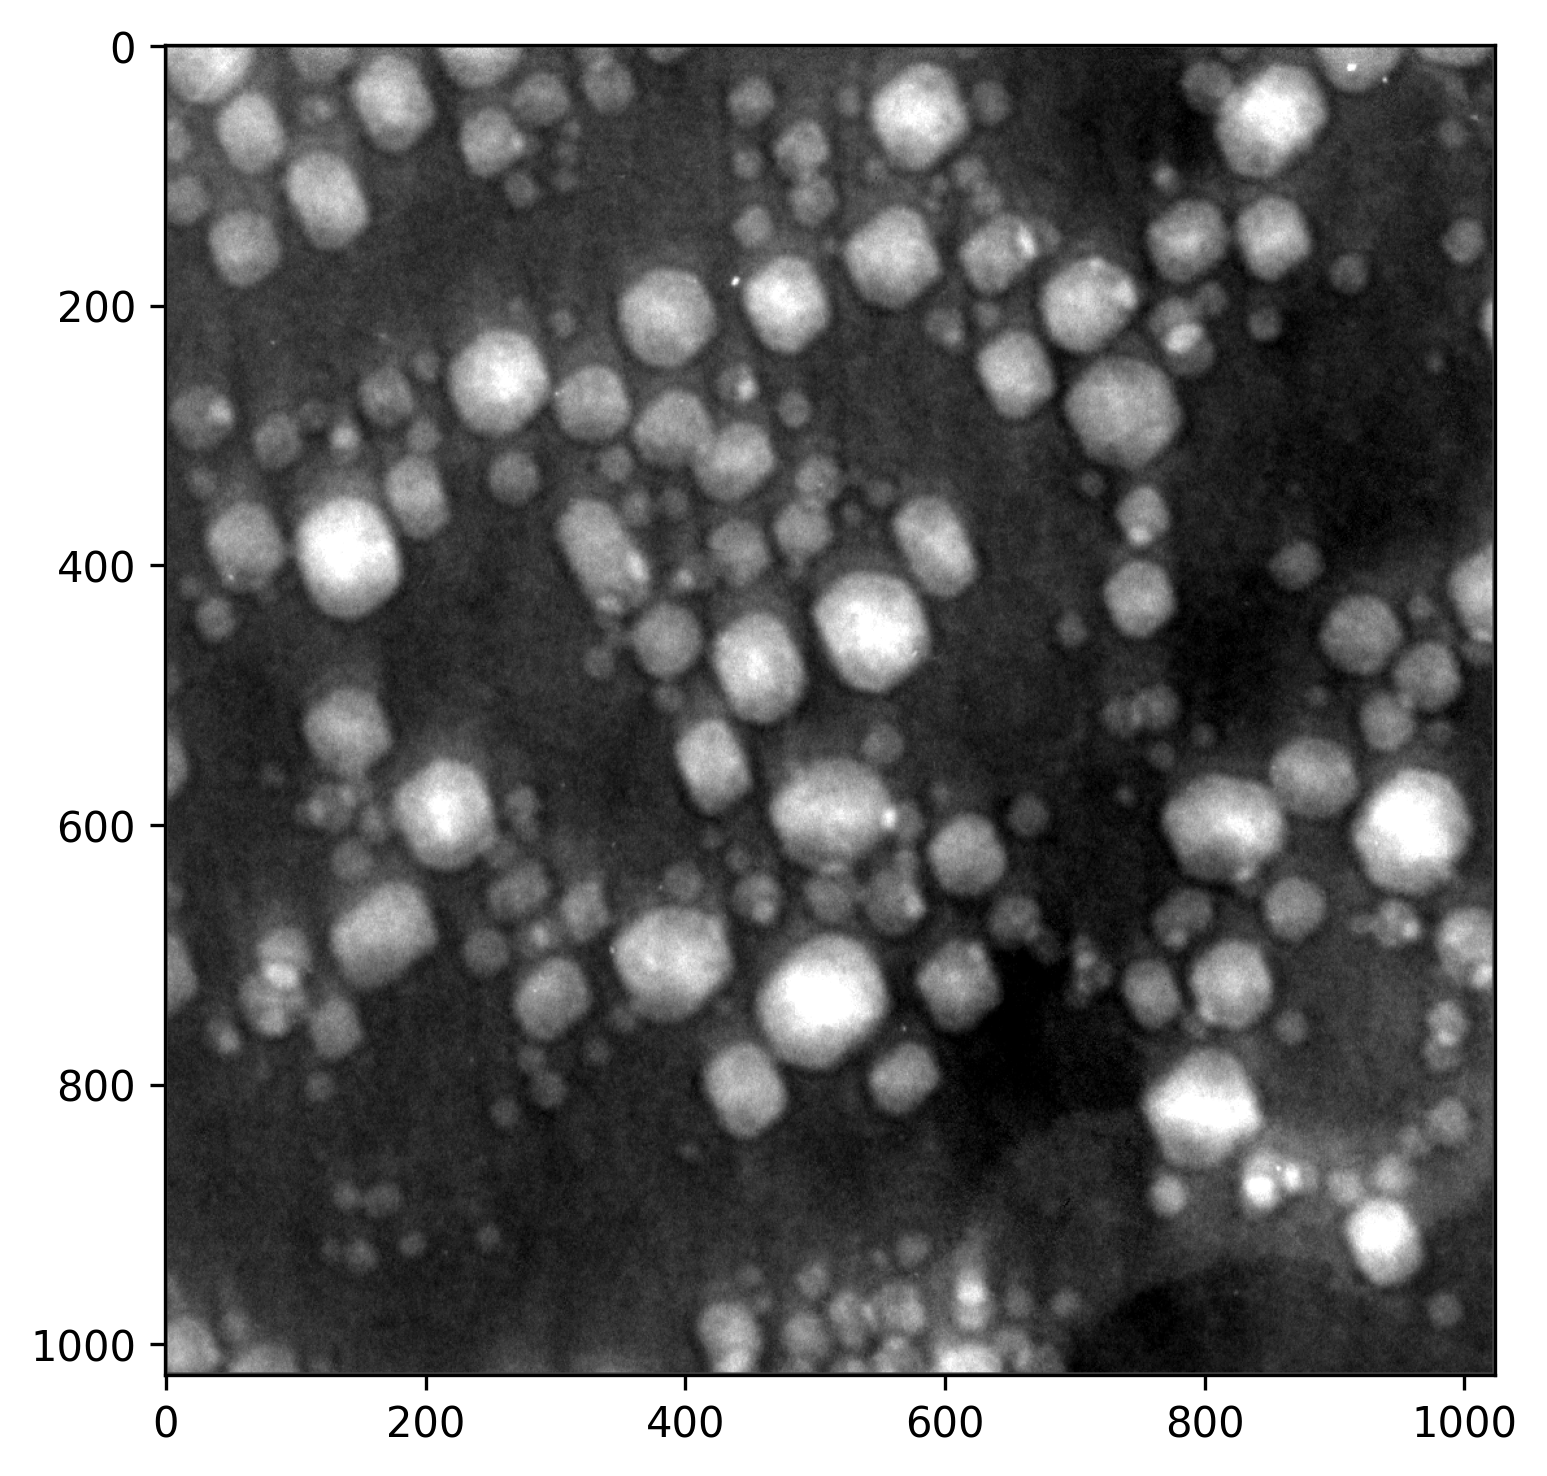

In [ ]:
fig1, ax = plt.subplots(1, 1, figsize=(5, 5))
fig1.tight_layout(pad=.5)
#ax.axis('off')
ax.imshow(test_images[0], cmap='gist_gray')

### Detection:

Define a function for the model:

In [ ]:
def get_instance_segmentation_model(hidden_layer=32, num_classes=2):
    # load an instance segmentation model pre-trained on COCO
    # v2 is a newer version

    model = torchvision.models.detection.maskrcnn_resnet50_fpn_v2(
        pretrained=True, box_detections_per_img=1000)

    # get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    # and replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
                                                       hidden_layer,
                                                       num_classes)

    return model

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
# get the model using our helper function
model = get_instance_segmentation_model(hidden_layer=32)
# move model to the right device
model.to(device)
model.load_state_dict(torch.load('bubbleMRCNN32layers_16873_epochs700_pretrained.pt', map_location=device))

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MaskRCNN_ResNet50_FPN_V2_Weights.COCO_V1`. You can also use `weights=MaskRCNN_ResNet50_FPN_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/maskrcnn_resnet50_fpn_v2_coco-73cbd019.pth" to /root/.cache/torch/hub/checkpoints/maskrcnn_resnet50_fpn_v2_coco-73cbd019.pth
100%|██████████| 177M/177M [00:00<00:00, 366MB/s]


<All keys matched successfully>

In [ ]:
# mount google drive
#from google.colab import drive
#drive.mount('/content/drive')
#import os
#os.chdir('/content/drive/your_directory')

Mounted at /content/drive


Define a function for prediction:

In [ ]:
def MRCNNpred(image):
    model.eval()
    with torch.no_grad():
        prediction = model([torch.as_tensor(image[None, ...], dtype=torch.float32).to(device)])
    return prediction

Perform detection using sliding window:

In [ ]:
def BubbleDetector(test_image=None, wsize=256, pad=64, score_thresh=.7, b=2, exclude_partial=True):
    # b = 2 since image has a 2 px wide border
    swsize = int(wsize-(2*pad))  # selecting window size
    orig_imsize = np.shape(test_image)[0]
    padded_img = np.zeros((orig_imsize+pad*2, orig_imsize+pad*2))
    padded_img[pad:orig_imsize+pad, pad:orig_imsize+pad] = test_image
    imsize = np.shape(padded_img)[0]
    pred_entire_image = np.zeros((imsize,imsize))

    x0 = 0; y0 = 0
    scores = np.array([]); boxes = np.zeros((1, 4))
    masks = np.zeros((1, orig_imsize, orig_imsize))
    for y in range(int(imsize/wsize*2-1)):
        y0 = swsize * y
        for x in range(int(imsize/wsize*2-1)):
            x0 = swsize * x
            window = padded_img[y0:y0+wsize, x0:x0+wsize]
            window_pred = MRCNNpred(window)[0]
            boxes_np = window_pred['boxes'].cpu().numpy()
            # find valid boxes within [64, 192[
            midpts = np.array([(boxes_np[:, 0]+boxes_np[:, 2])/2, (boxes_np[:, 1]+boxes_np[:, 3])/2]).T
            valid_midptsBM = (((pad<=midpts[:,0])==(midpts[:,0]<pad+swsize)).astype(int)+((pad<=midpts[:,1])==(midpts[:,1]<pad+swsize)).astype(int)) == 2 # both are true
            # find valid scores
            valid_scoresBM = window_pred['scores'].cpu().numpy() > score_thresh

            if exclude_partial == False:
                # find valid objects
                valid_idx = (valid_midptsBM.astype(int)+valid_scoresBM.astype(int)) == 2  # both are true
            else:
                # find objects not on edges
                valid_boxBMx = []; valid_boxBMy = []; valid_boxBM = []
                if x0 == 0:
                    valid_boxBMx = boxes_np[:,0]>pad+b
                    valid_boxBM = valid_boxBMx
                elif x0 == swsize*int(imsize/wsize*2-2):
                    valid_boxBMx = boxes_np[:,2]<wsize-pad-b
                    valid_boxBM = valid_boxBMx
                if y0 == 0:
                    valid_boxBMy = boxes_np[:,1]>pad+b
                    valid_boxBM = valid_boxBMy
                elif y0 == swsize*int(imsize/wsize*2-2):
                    valid_boxBMy = boxes_np[:,3]<wsize-pad-b
                    valid_boxBM = valid_boxBMy
                if len(valid_boxBMx) != 0 and len(valid_boxBMy) != 0:
                    valid_boxBM = (valid_boxBMx.astype(int)+valid_boxBMy.astype(int)) == 2
                # find valid objects
                if len(valid_boxBM) != 0:
                    valid_idx = (valid_midptsBM.astype(int)+valid_scoresBM.astype(int)+valid_boxBM.astype(int)) == 3  # all are true
                else:
                    valid_idx = (valid_midptsBM.astype(int)+valid_scoresBM.astype(int)) == 2 # both are true

            valid_scores = window_pred['scores'].cpu().numpy()[valid_idx]
            valid_boxes = window_pred['boxes'].cpu().numpy()[valid_idx]
            # calculate coords in padded image
            valid_boxes[:, [0, 2]] = valid_boxes[:, [0, 2]] + x0    # x1, x2
            valid_boxes[:, [1, 3]] = valid_boxes[:, [1, 3]] + y0    # y1, y2
            # calculate coords in original image
            valid_boxes = valid_boxes - pad
            # place the mask in padded image
            valid_masks = window_pred['masks'].cpu().numpy()[valid_idx][:, 0, ...]
            valid_masks_large = np.zeros((len(valid_scores), imsize, imsize))
            valid_masks_large[:, y0:y0+wsize, x0:x0+wsize] = valid_masks
            # crop mask to shape of original image
            valid_masks_large = valid_masks_large[:, pad:orig_imsize+pad, pad:orig_imsize+pad]

            scores = np.append(scores, valid_scores)
            boxes = np.concatenate((boxes, valid_boxes), axis=0)
            masks = np.concatenate((masks, valid_masks_large), axis=0)

    return {'id':[*range(len(scores))], 'scores':scores, 'boxes':boxes[1:, ...], 'masks':masks[1:, ...]}

Make detection of image stack:

In [ ]:
results_dict = []
for img in test_images:
    results_dict.append(BubbleDetector(img))
    print('processed image')

processed image
processed image
processed image
processed image
processed image
processed image
processed image
processed image
processed image
processed image
processed image
processed image
processed image
processed image
processed image
processed image
processed image
processed image
processed image
processed image
processed image
processed image
processed image
processed image
processed image
processed image
processed image
processed image
processed image
processed image


Process detections into appropriate array format [x1 y1 x2 y2 frame_no]:

In [ ]:
coord_allframe = np.zeros((1, 5))
for i in range(len(results_dict)):
    result = results_dict[i]
    coord_frame = result['boxes']
    frame_nums = np.full((len(coord_frame), 1), i)
    coord_frame = np.append(coord_frame, frame_nums, axis=1)
    coord_allframe = np.append(coord_allframe, coord_frame, axis=0)
coord_allframe = coord_allframe[1:]

Perform bubble tracking:

In [ ]:
f0bubbles = coord_allframe[np.where(coord_allframe[:,-1]==0)]
print(f'{len(f0bubbles)} bubbles in frame 0')
tracked_stack = []

for i in range(len(f0bubbles)):
    tracked_bubble = []
    next_bubble = coord_allframe[i]
    f_no = 1
    max_frame = np.max(coord_allframe[:, -1])
    ind = [0]
    while True:
        tracked_bubble.append(next_bubble)
        search_space = coord_allframe[coord_allframe[:, -1]==f_no]
        tree = sklearn.neighbors.KDTree(search_space[:, :-1])
        _, ind = tree.query([next_bubble[:-1]], k=1)
        if ind[0].size == 0:
            break
        next_bubble = search_space[int(ind[0][0])] # 1st is closest
        if f_no < max_frame:
            f_no = f_no + 1
        else:
            tracked_bubble.append(next_bubble)
            break
    tracked_bubbles = np.vstack(tracked_bubble)
    tracked_stack.append(tracked_bubbles)
    print(f'tracked bubble {i+1} / {len(f0bubbles)} bubbles across {f_no+1} frames')

201 bubbles in frame 0
tracked bubble 1 / 201 bubbles across 30 frames
tracked bubble 2 / 201 bubbles across 30 frames
tracked bubble 3 / 201 bubbles across 30 frames
tracked bubble 4 / 201 bubbles across 30 frames
tracked bubble 5 / 201 bubbles across 30 frames
tracked bubble 6 / 201 bubbles across 30 frames
tracked bubble 7 / 201 bubbles across 30 frames
tracked bubble 8 / 201 bubbles across 30 frames
tracked bubble 9 / 201 bubbles across 30 frames
tracked bubble 10 / 201 bubbles across 30 frames
tracked bubble 11 / 201 bubbles across 30 frames
tracked bubble 12 / 201 bubbles across 30 frames
tracked bubble 13 / 201 bubbles across 30 frames
tracked bubble 14 / 201 bubbles across 30 frames
tracked bubble 15 / 201 bubbles across 30 frames
tracked bubble 16 / 201 bubbles across 30 frames
tracked bubble 17 / 201 bubbles across 30 frames
tracked bubble 18 / 201 bubbles across 30 frames
tracked bubble 19 / 201 bubbles across 30 frames
tracked bubble 20 / 201 bubbles across 30 frames
tracke

Show an example of a tracked bubble. Each bubble is in an array with columns [x1 y1 x2 y2 frame_num].

In [ ]:
print(tracked_stack[0])

[[ 34.2984848   28.74833679  99.26875305 101.95413208   0.        ]
 [ 35.89086914  29.71698761  97.25543213 103.94862366   1.        ]
 [ 33.82535553  34.54441071  98.40454102 105.87255859   2.        ]
 [ 34.84896088  37.14208984  97.91607666 106.84844971   3.        ]
 [ 35.99443054  37.18586731  99.98408508 108.75640869   4.        ]
 [ 34.61550903  38.88867188 101.11010742 111.65888977   5.        ]
 [ 35.29570007  37.87062073  97.66442871 109.59559631   6.        ]
 [ 32.21474457  37.81180573  97.15765381 109.80358887   7.        ]
 [ 28.98023224  38.08043671  94.74198914 109.2820282    8.        ]
 [ 29.06302643  38.27306366  93.52883911 110.02371216   9.        ]
 [ 28.54569244  40.51007843  91.87059021 111.06665039  10.        ]
 [ 27.01190948  41.77770996  90.94338989 112.72148132  11.        ]
 [ 26.88479614  43.23896027  89.92285156 114.64405823  12.        ]
 [ 22.77745056  45.65523529  87.63113403 117.78486633  13.        ]
 [ 22.25340271  45.31983948  88.46356201 117.379

Draw the bounding boxes:

In [ ]:
# make 1D grayscale image into 3D grayscale image
def grayscale1Dto3D(img1d):
    img3d = np.zeros([img1d.shape[0], img1d.shape[1], 3])
    for i in range(3):
        img3d[..., i] = img1d
    return img3d

# takes 3D img to draw bounding box and label of a single bubble
def drawBoxes(img, points, bubble_num):
    img = cv2.rectangle(img, points[0, 0:2], points[0, 2:4], color=(1,0,0))
    img = cv2.putText(img, str(bubble_num), org=points[0, 2:4]+1, fontFace=cv2.FONT_HERSHEY_PLAIN, fontScale=1, color=(1,0,0))
    return img

In [ ]:
# draw all the bounding boxes with bubble number
pred2Dboxed_series = []
for i in range(len(test_images)): # each frame
    frame = np.copy(test_images[i])
    frame = grayscale1Dto3D(frame)
    for j in range(len(tracked_stack)): # each bubble across all frames
        tracked_bubble = tracked_stack[j]
        draw_coords = tracked_bubble[tracked_bubble[:, -1] == i].astype(int)
        if np.sum(draw_coords) > 0: # check if bubble still exist
            frame = drawBoxes(frame, draw_coords, j)
    pred2Dboxed_series.append(frame)

Display examples of tracked bubbles (uncomment to show if desired):

In [ ]:
#fig1, ax = plt.subplots(1, len(pred2Dboxed_series), figsize=(30, 40))
#for i in range(len(pred2Dboxed_series)):
#    ax[i].imshow(pred2Dboxed_series[i])
#    ax[i].axis('off')

## Convert into video:

In [ ]:
def make_frame(t):
    t = int(t)
    vidframe = pred2Dboxed_series[t] * 255
    vidframe = vidframe.astype(int)
    return vidframe

In [ ]:
import moviepy.editor as mpy
clip = mpy.VideoClip(make_frame, duration=int(len(pred2Dboxed_series)))

clip.write_videofile('PdNi_video_tracking_30frames.mp4', fps=10)

Moviepy - Building video PdNi_video_tracking_30frames.mp4.
Moviepy - Writing video PdNi_video_tracking_30frames.mp4



Moviepy - Done !
Moviepy - video ready PdNi_video_tracking_30frames.mp4
